In [95]:
pip install pandas matplotlib numpy scikit-learn scipy seaborn 


[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ----- ---------------------------------- 41.0/294.9 kB 1.9 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 4.5 MB/s eta 0:00:00


# Preparing the data

In [96]:
# 1. Firstly, before we construct the CRO algorithm we will need to load in our data that we will train the model with
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns

# Load in data from CSV file, I used Kaggle for this
data_csv = pd.read_csv("GaltonFamilies.csv")

In [80]:
# Remember that regression uses only quantitative variables, so we should filter columns with any non number columns

# Identify numerical columns
numerical_columns = data_csv.select_dtypes(include=['number']).columns

# Create a new DataFrame with only numerical columns
data_csv = data_csv[numerical_columns]


# Testing when looking at only specified columns
columns_to_keep = ['father', 'childHeight']
data_csv = data_csv[columns_to_keep]


In [81]:
data_csv.head

<bound method NDFrame.head of      father  childHeight
0      78.5         73.2
1      78.5         69.2
2      78.5         69.0
3      78.5         69.0
4      75.5         73.5
..      ...          ...
929    62.0         64.0
930    62.0         62.0
931    62.0         61.0
932    62.5         66.5
933    62.5         57.0

[934 rows x 2 columns]>

In [82]:
# plt.plot(data_csv["mother"], data_csv["father"], 'o')

# Clustering the data

C:\Users\willi\AppData\Local\Temp\ipykernel_508\3578446807.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interval_data['cluster'] = kmeans.labels_
C:\Users\willi\AppData\Local\Temp\ipykernel_508\3578446807.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interval_data['cluster'] = kmeans.labels_
C:\Users\willi\AppData\Local\Temp\ipykernel_508\3578446807.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

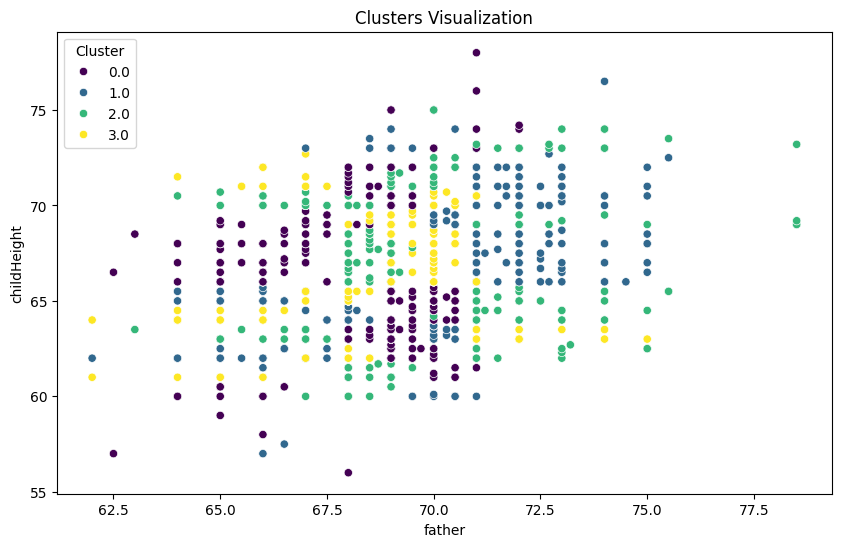

In [99]:
# We will cluster our data into approximated points with the following logic:

"""
Choose an arbitrary dimension, then go from intervals [min < X < max], look at all data points within interval (X#, X#+1) then generate averages for each cluster
"""

# First sort our data set given the row we choose (usually the variable we are most interested in)
chosen_column = 'childHeight'
interval_step = 1  # Define the step for intervals

# Sort the dataset by the chosen column
data_csv_sorted = data_csv.sort_values(by=chosen_column)

# Get the min and max values of the chosen column
min_value = data_csv_sorted[chosen_column].min()
max_value = data_csv_sorted[chosen_column].max()



# Function to determine the optimal number of clusters
def determine_optimal_clusters(data, max_clusters=10, sensitivity=0.1):
    if len(data) <= 1:
        return 1  # Can't cluster if there's only one point
    distortions = []
    for k in range(1, min(len(data), max_clusters) + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    # Heuristic: choose the number of clusters where the reduction in inertia decreases significantly
    k_opt = 1
    for i in range(1, len(distortions)):
        if distortions[i-1] - distortions[i] < sensitivity * (distortions[0] - distortions[-1]):
            k_opt = i
            break
    return k_opt + 1

# Create a function to cluster and calculate averages
def cluster_and_average(data, column, step, max_clusters=10, sensitivity=0.1):
    clusters = []
    cluster_assignments = []
    current_interval_start = min_value
    
    while current_interval_start < max_value:
        current_interval_end = current_interval_start + step
        # Select data points within the current interval
        interval_data = data[(data[column] >= current_interval_start) & (data[column] < current_interval_end)]
        
        if not interval_data.empty:
            interval_data_numeric = interval_data.select_dtypes(include=['number'])
            
            # Determine the optimal number of clusters
            n_clusters = determine_optimal_clusters(interval_data_numeric, max_clusters, sensitivity)
            
            # Apply K-means clustering to the interval data
            kmeans = KMeans(n_clusters=n_clusters)
            kmeans.fit(interval_data_numeric)
            interval_data['cluster'] = kmeans.labels_
            
            # Store cluster assignments for visualization
            cluster_assignments.append(interval_data[['cluster']])
            
            # Calculate the mean for each cluster
            for cluster in range(n_clusters):
                cluster_data = interval_data[interval_data['cluster'] == cluster]
                cluster_mean = cluster_data.mean(numeric_only=True)
                clusters.append(cluster_mean)
        
        current_interval_start = current_interval_end

    return pd.DataFrame(clusters), pd.concat(cluster_assignments)

# Apply the clustering and averaging function
clustered_data, cluster_assignments = cluster_and_average(data_csv_sorted, chosen_column, interval_step)

# Add cluster assignments back to the original data for visualization
data_csv_sorted['cluster'] = cluster_assignments

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_csv_sorted, x='father', y='childHeight', hue='cluster', palette='viridis')
plt.title('Clusters Visualization')
plt.xlabel('father')
plt.ylabel('childHeight')
plt.legend(title='Cluster')
plt.show()



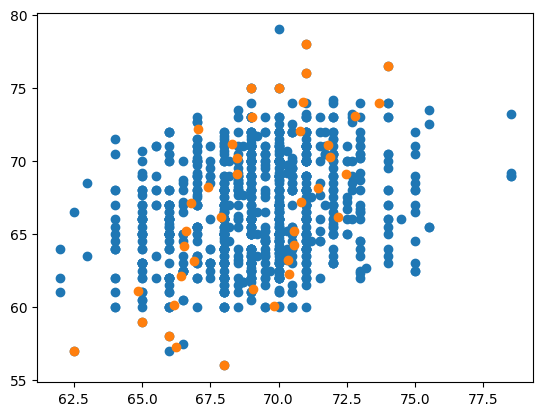

In [93]:
plt.plot(data_csv["father"], data_csv["childHeight"], 'o')
plt.plot(clustered_data["father"], clustered_data["childHeight"], 'o')

# Connecting approximation points

In [85]:
# Connect each cluster with another node that has the best (density - distance) value, lets define the functions below...

density_bias = 1
distance_bias = 1

def density_value(p1, p2):
    # calculated via
    # (# of data in area between two points) / (size of the area) * density_bias
    pass

def distance_value(p1, p2):
    # calculated via
    # point distance * distance_bias
    pass